# Introduction

In this notebook, we want to analyze eviction data in nyc using DBSCAN and kmeans clustering algos. Following the previous notebook, we use the cleaned data to test on both techniques and compare their results. Quick viz and metrics are provided to assess the effectiveness of each approach.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# !pip install geopandas contextily
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import Point

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio
import contextily as ctx

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1 Get the Eviction data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'

In [ ]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [ ]:
evictions_cleaned = evictions_cleaned_raw.copy()

In [ ]:
evictions_cleaned.head(2)

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,bin,bbl,nta,geometry,eviction_count,year,average_year_eviction_count,cluster,cluster_k,same_cluster
0,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,...,3143881.0,3.057940e+09,Sunset Park East,POINT (-74.011883 40.635941),3,2024,3.0,0,0,True
1,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,40.640008,...,3143435.0,3.057820e+09,Sunset Park West,POINT (-74.017068 40.640008),3,2024,3.0,0,0,True


In [ ]:
evictions_cleaned.columns, \
evictions_cleaned.shape

(Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
        'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
        'same_cluster'],
       dtype='object'),
 (76484, 24))

### Skipped these sections and subsections (see notebook part 1)

# Part 2 Get to know the GeoDataFrame

## Part 2.1 Aggregation to find eviction counts (with BBL)

## Part 2.2 Visualize the GeoDataFrame -- Plotly and Folium

# Part 3 Clustering

## Part 3.1 Buildings with the most evictions (top_bbls)

## Part 3.2 DBSCAN

- Density-based spatial clustering of applications with noise (DBSCAN) is a clustering algorithm used in machine learning to partition data into clusters based on their distance to other points. Its effective at identifying and removing noise in a data set, making it useful for data cleaning and outlier detection.

##### source: https://builtin.com/articles/dbscan#:~:text=What%20Is%20DBSCAN%3F,their%20distance%20to%20other%20points.
##### inspirations: https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data

### Part 3.2.1 Prepare the data for DBSCAN test

- Why didn't log the average eviction data points first?

- We have tried log it first before send the data for further processing, but it only yields one cluster. Therefore logging it just compress the data too much and therefore it is not a good way to process the data in this case

- We chose DBSCAN here, because it does not presumbly ask for the number of clusters, whereas K means does. K means also assume the clusters are in circular form, which may not be the case with geo data

### Part 3.2.1 Prepare the data for DBSCAN
### Part 3.2.2 Apply DBSCAN

In [ ]:
# use eviction_count for clustering
eviction_counts = evictions_cleaned[['average_year_eviction_count']]

In [ ]:
# normalize the eviction_counts
scaler = StandardScaler()
eviction_counts_scaled = scaler.fit_transform(eviction_counts)

In [ ]:
# apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=3)
evictions_cleaned['cluster'] = dbscan.fit_predict(eviction_counts_scaled)

In [ ]:
# analyze the number of clusters formed and noise points
n_clusters = len(set(evictions_cleaned['cluster'])) - (1 if -1 in evictions_cleaned['cluster'] else 0)
n_noise = list(evictions_cleaned['cluster']).count(-1)

print("results: number of clusters: ", n_clusters, "number of noise points: ", n_noise)

## no noise, 3 clusters, luckily good

results: number of clusters:  3 number of noise points:  0


In [ ]:
# -1 would be noise label
print(evictions_cleaned['cluster'].unique())

[0 1 2]


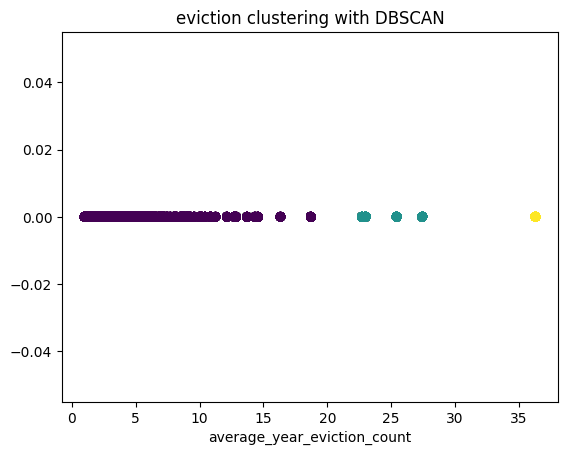

In [ ]:
# visualize the clusters
plt.scatter(evictions_cleaned['average_year_eviction_count'], [0]*len(evictions_cleaned), c=evictions_cleaned['cluster'], cmap='viridis')
plt.xlabel('average_year_eviction_count')
plt.title('eviction clustering with DBSCAN')
plt.show()

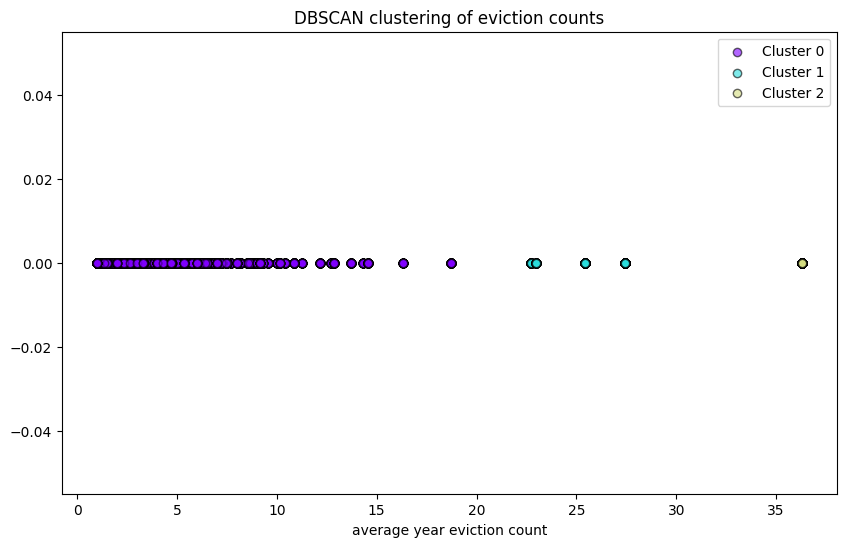

In [ ]:
# better visuals
plt.figure(figsize=(10, 6))

for cluster_id in set(evictions_cleaned['cluster']):
    # default: noise points
    if cluster_id == -1:
        color = 'black'
        # luckily, we don't have noise in this case.
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / n_clusters)
        label = f'Cluster {cluster_id}'

    plt.scatter(evictions_cleaned[evictions_cleaned['cluster'] == cluster_id]['average_year_eviction_count'],
                [0] * len(evictions_cleaned[evictions_cleaned['cluster'] == cluster_id]),
                color=color, label=label, alpha=0.6, edgecolor='k')

plt.title('DBSCAN clustering of eviction counts')
plt.xlabel('average year eviction count')
plt.legend()
plt.show()